# Hazard: Tropical cyclone surge from linear wind-surge relationship and a bathtub model

The `TCSurgeBathtub` class models surges generated by tropical cyclones. Given an elevation data set and a `TropCyclone` instance, it computes the surges for each historical and/or synthetic event at every centroid. `TCSurgeBathtub` inherits from `Hazard` and has an associated hazard type `TCSurgeBathtub`.

## Model description

As a first approximation, the tropical cyclone's wind field in each grid cell is used as an input to a simplified version of the **wind-surge relationship** in [Xu (2010)](https://ams.confex.com/ams/pdfpapers/168806.pdf), which is based on pre-run [SLOSH](http://www.nhc.noaa.gov/surge/slosh.php) outputs.

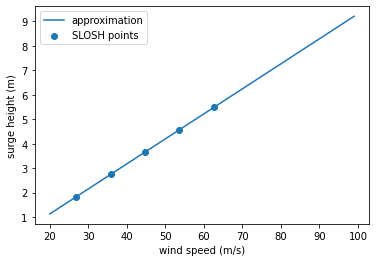

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# conversion factors
mph2ms = 0.44704;
f2m = 0.3048;

# the points read from the SLOSH graph
v0 = 60*mph2ms;
v1 = 140*mph2ms;
s0 = 6*f2m;
s1 = 18*f2m;

# the parameters for the linear function: a*(v-v0)+s0
a = (s1-s0)/(v1-v0)

# graphical representation
v = np.arange(20, 100)
vmph = np.arange(60, 141, 20)

plt.plot(v, a*(v-v0)+s0, label='approximation')
plt.scatter(vmph*mph2ms, a*(vmph*mph2ms-v0)+s0, label='SLOSH points')
plt.xlabel('wind speed (m/s)')
plt.ylabel('surge height (m)')
plt.legend()
plt.show()

The elevation of the centroids is then substracted from the surge using the user-specified elevation data set. The elevation data set has to be given as a path to a GeoTIFF grid data file that covers the region affected by the tropical cyclone. A global data set is freely available as [SRTM15+V2.0](https://figshare.com/projects/SRTM15_V2_0/62045) (used in the example below). The improved-quality [CoastalDEM](https://go.climatecentral.org/coastaldem/) data set is available on request from [Climate Central](https://go.climatecentral.org/coastaldem/).

In a final step, a decay of the surge height depending on the distance from the coastline by 0.2 meters per kilometer is implemented following [Pielke and Pielke (1997)](https://rogerpielkejr.com/2016/10/10/hurricanes-their-nature-and-impacts-on-society/).

Optionally, a user-specified sea level rise offset is added to the result.



## Example

We compute the surges of Sidr 2007 and Roanu 2016 over Bangladesh as follows:

2020-11-26 17:40:05,396 - climada - DEBUG - Loading default config file: /home/tovogt/code/climada_python/climada/conf/defaults.conf
2020-11-26 17:40:06,983 - climada.hazard.tc_tracks - INFO - Progress: 50%
2020-11-26 17:40:07,005 - climada.hazard.tc_tracks - INFO - Progress: 100%
2020-11-26 17:40:07,014 - climada.hazard.tc_tracks - INFO - Interpolating 2 tracks to 0.5h time steps.


/home/tovogt/.local/share/miniconda3/envs/tc/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/tovogt/.local/share/miniconda3/envs/tc/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/tovogt/.local/share/miniconda3/envs/tc/lib/python3.7/site-packages/cartopy/mpl/feature_artist.py:215: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **style)


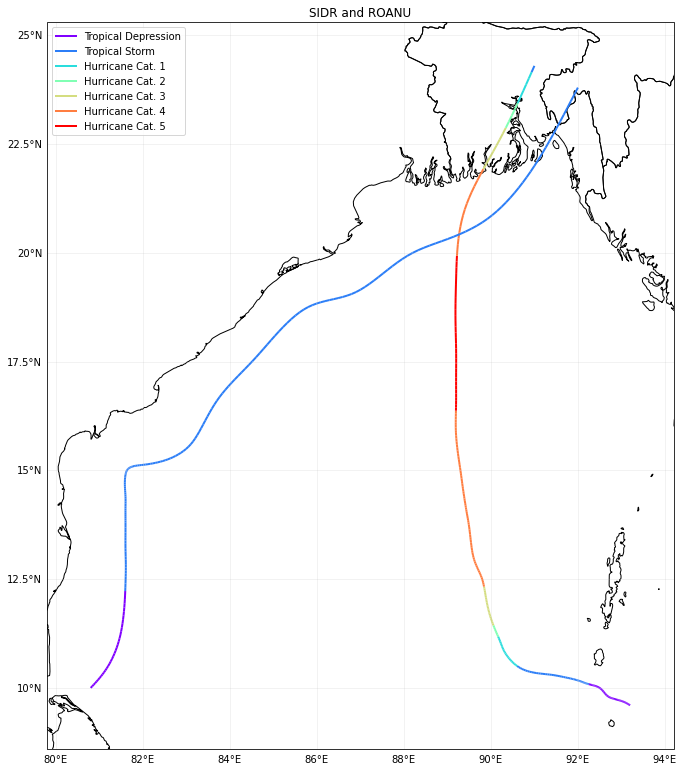

In [2]:
%matplotlib inline
# 1: tracks retrieval
from climada.hazard import TCTracks

tr_usa = TCTracks()
tr_usa.read_ibtracs_netcdf(provider='usa', storm_id=['2007314N10093', '2016138N10081']) # SIDR 2007 and ROANU 2016
tr_usa.equal_timestep(0.5)
ax = tr_usa.plot()
ax.get_legend()._loc = 2 # correct legend location
ax.set_title('SIDR and ROANU'); # set title

In [3]:
# 2: wind gusts computation
from climada.hazard import TropCyclone, Centroids

# define centroids raster
min_lat, max_lat, min_lon, max_lon = 20, 27, 88.5, 92.5
cent_bang = Centroids()
cent_bang.set_raster_from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.015)
cent_bang.set_dist_coast(signed=True, precomputed=True)
cent_bang.check()

tc_bang = TropCyclone()
tc_bang.set_from_tracks(tr_usa, centroids=cent_bang)

2020-11-26 17:40:09,005 - climada.util.coordinates - INFO - Sampling from /home/tovogt/code/climada_python/data/system/GMT_intermediate_coast_distance_01d.tif
2020-11-26 17:40:09,103 - climada.hazard.trop_cyclone - INFO - Mapping 2 tracks to 125424 centroids.
2020-11-26 17:40:20,032 - climada.hazard.trop_cyclone - INFO - Progress: 50%


In [4]:
# 3: surge computation
from climada.hazard import TCSurgeBathtub
from climada.util.constants import SYSTEM_DIR
import os

# make sure that the global SRTM15+V2.0 elevation data set is in CLIMADA's SYSTEM_DIR:
topo_path = os.path.join(SYSTEM_DIR, 'SRTM15+V2.tiff')
ts_bang = TCSurgeBathtub.from_tc_winds(tc_bang, topo_path)

2020-11-26 17:40:27,562 - climada.util.coordinates - INFO - Sampling from /home/tovogt/code/climada_python/data/system/SRTM15+V2.tiff


2020-11-26 17:40:27,711 - climada.util.coordinates - INFO - Sampling from /home/tovogt/code/climada_python/data/system/SRTM15+V2.tiff


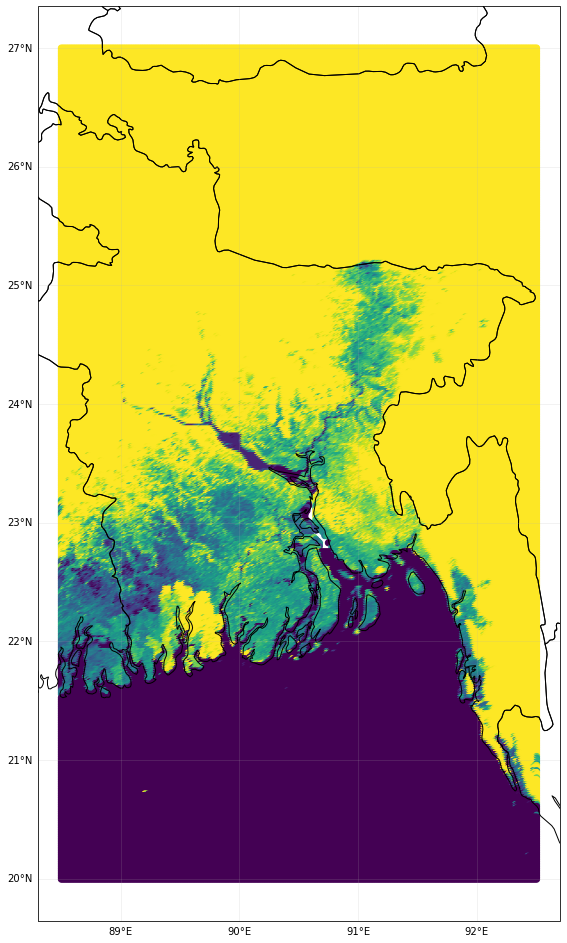

In [5]:
# plot elevation of the raster
ts_bang.centroids.set_elevation(topo_path)
ts_bang.centroids.plot(c=ts_bang.centroids.elevation, vmin=0, vmax=10)

Text(0.5, 1.0, 'Surge SIDR 2007')

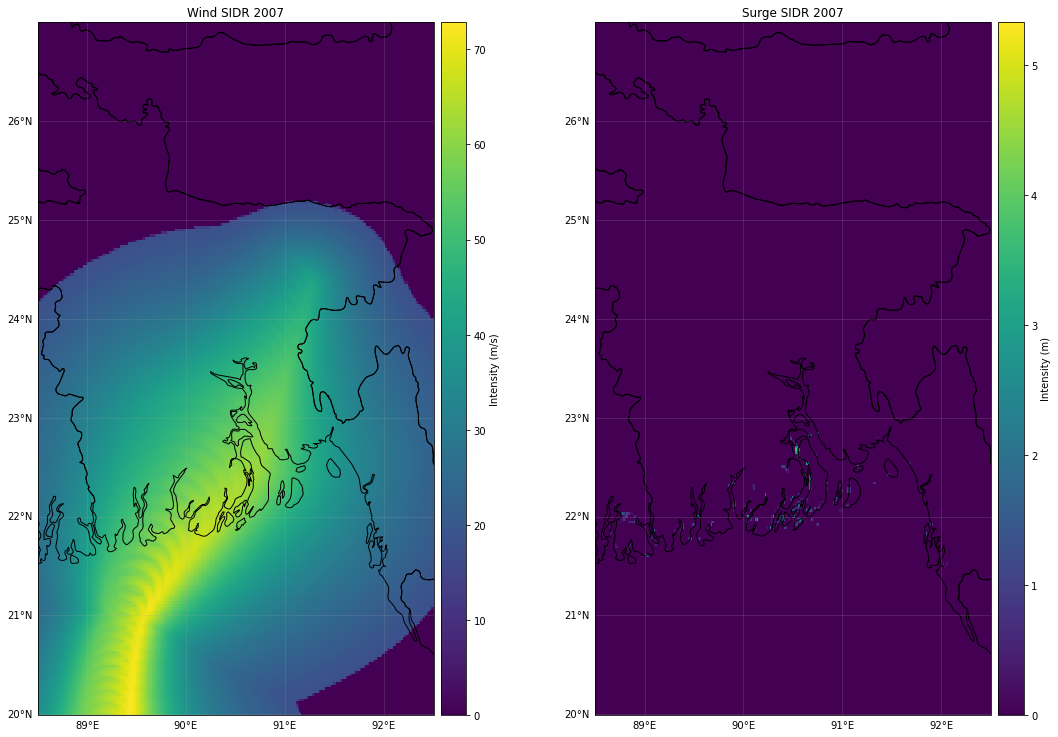

In [6]:
# plot wind and surge SIDR
from climada.util.plot import make_map

fig, ax = make_map(2, figsize=(14, 14))
tc_bang.plot_intensity(1, axis=ax[0])
ts_bang.plot_intensity(1, axis=ax[1])
ax[0].set_title('Wind SIDR 2007')
ax[1].set_title('Surge SIDR 2007')

Text(0.5, 1.0, 'Surge ROANU 2016')

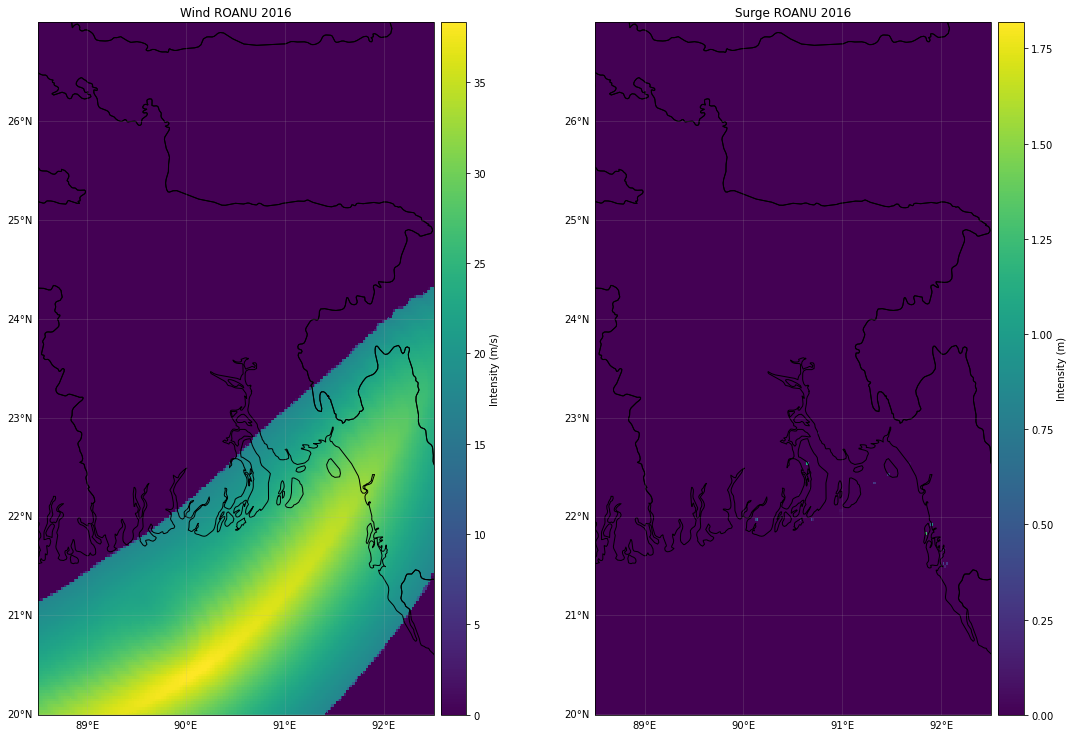

In [7]:
# plot wind and surge ROANU
from climada.util.plot import make_map

fig, ax = make_map(2, figsize=(14, 14))
tc_bang.plot_intensity(2, axis=ax[0])
ts_bang.plot_intensity(2, axis=ax[1])
ax[0].set_title('Wind ROANU 2016')
ax[1].set_title('Surge ROANU 2016')